In [56]:
import os
import seaborn as sns
sns.set()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, namedtuple
from io import StringIO
import re
from IPython.display import display, Latex

In [2]:
def get_results(res_path):
    # group file names by configuration
    results_by_specs = defaultdict(list)
    for fname in os.listdir(res_path):
        if not fname.endswith('.txt'):
            continue

        try:
            spec, day, hour = fname[:-len('.txt')].split('-')
            _, model, features, trend, most = spec.split('_')
        except:
            print('skipping', fname)
            continue

        results_by_specs[(model, features, trend, most)].append(fname)
    
    # for each config, find and parse most recent result file
    df_rows, df_cols = [], None
    for spec, files in results_by_specs.items():
        res_file, res_lines, found = list(sorted(files))[-1], [], False
        with open(os.path.join(res_path, res_file)) as f:
            for i, row in enumerate(f):
                rr = row.strip()
                
                if found and not rr.startswith('**'):
                    res_lines.append(rr)
                elif found and rr.startswith('**'):
                    break
                elif not found and rr.startswith('**raw scores'):
                    found = True
            
        assert res_lines

        csv_text = re.sub('[ \t]+', ',', '\n'.join(res_lines))
        metrics_df = pd.read_csv(StringIO(csv_text))
        for col in metrics_df:
            for val in metrics_df[col]:
                df_rows.append(list(spec) + [col, val])

        if df_cols is None:
            df_cols = [
                'estimator', 'features', 'trend', 'most', 'metric', 'value'
            ]

    results = pd.DataFrame(df_rows, columns=df_cols)
    return results


res = get_results('data/cabauw/results')
res.head(5)

,estimator,features,trend,most,metric,value
0,Ridge,f3,notrend,most,explained_variance_score,0.676941
1,Ridge,f3,notrend,most,explained_variance_score,0.677849
2,Ridge,f3,notrend,most,explained_variance_score,0.690274
3,Ridge,f3,notrend,most,explained_variance_score,0.670385
4,Ridge,f3,notrend,most,explained_variance_score,0.676182


In [3]:
def paint_boxplot(bplot, all_color=None, **kwargs):
    # use all_color to paing all elements of the same color
    # or specify color for each element in kwargs
    # kwargs take precedence over all_color
    #
    # NB available elements are
    # boxes, medians, whiskers, caps, fliers, means

    for key in bplot:
        color = kwargs.get(key, all_color)
        if color:
            for element in bplot[key]:
                if key == 'boxes':
                    import pdb;
                element.set_color(color)


def make_base_plot(res, estimator, most, metric, save_path=None):
    most = 'most' if most else 'nomost'
    plot_data, found = [], False
    fig, ax = plt.subplots()

    for features in range(1, 6):
        for tidx, trend in enumerate(['trend', 'notrend']):
            vals = res[
                (res.estimator == estimator) &
                (res.most == most) &
                (res.features == 'f%d' % features) &
                (res.trend == trend) & 
                (res.metric == metric)
            ]['value'].values
            
            if vals.size == 0:
                plot_data.append([])
                continue

            plt.scatter([3 * (features - 1) + tidx] * len(vals), vals,
                        color='C%d' % tidx, s=7, zorder=10)

            plot_data.append(vals)
            found = True

    assert found, 'no results'

    # trend
    bp1 = ax.boxplot(plot_data[::2], positions=range(0, 15, 3),
                     showmeans=True, patch_artist=False, zorder=5)
    paint_boxplot(bp1, 'C0')

    # no trend
    bp2 = ax.boxplot(plot_data[1::2], positions=range(1, 15, 3),
                     showmeans=True, patch_artist=False, zorder=5)
    paint_boxplot(bp2, 'C1')
    
    # most baseline
    #most_mean, most_std = 0.332056, 0.017246
    #bot, top = most_mean - 2 * most_std, most_mean + 2 * most_std
    #plt.plot([-1, 14], [most_mean, most_mean], c='C4')
    #ax.fill_between([-1, 14], [bot, bot], [top, top], alpha=0.25, color='C4')
    
    ax.set_xlim(-1, 14)
    ax.set_xticks([0.5, 3.5, 6.5, 9.5, 12.5])
    ax.set_xticklabels(['F1', 'F2', 'F3', 'F4', 'F5'])
    
    fig.tight_layout()
    
    if save_path is not None:
        fig.savefig(os.path.join(
            save_path, 'result_%s_%s_%s.png' % (estimator, most, metric)
        ))
    
    ax.set_title(estimator + ' - ' + metric.replace('_', ' '))

    return fig, ax

## generation of charts

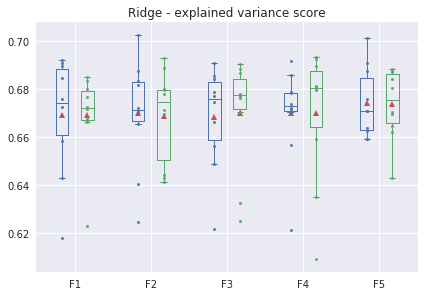

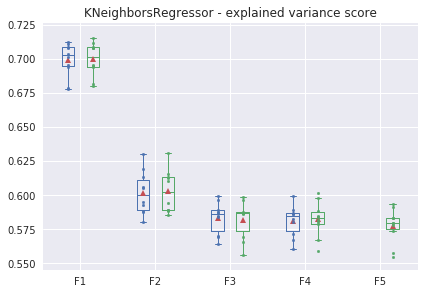

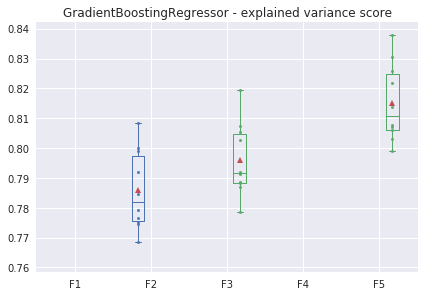

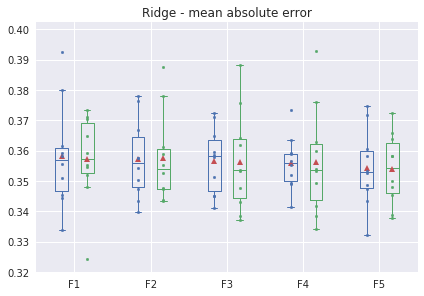

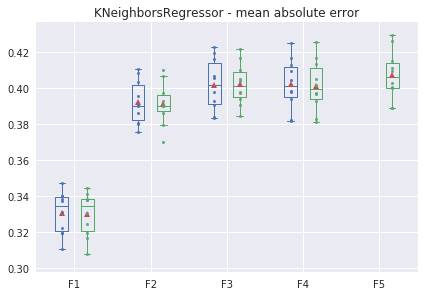

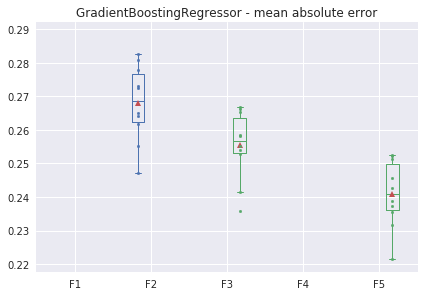

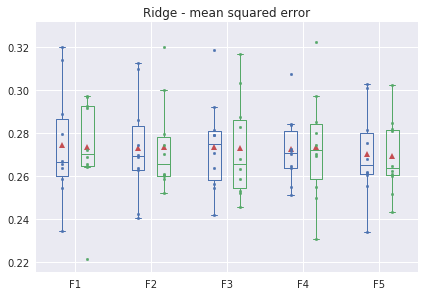

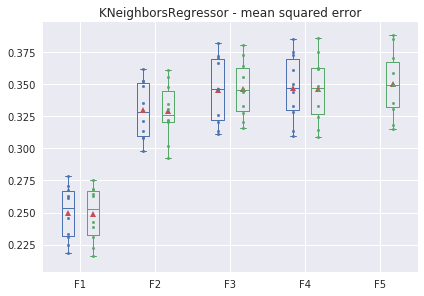

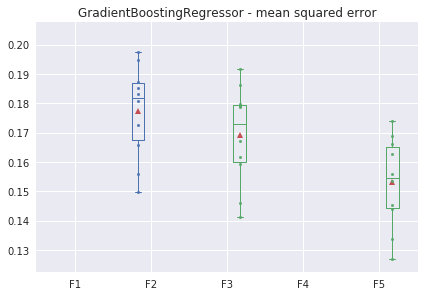

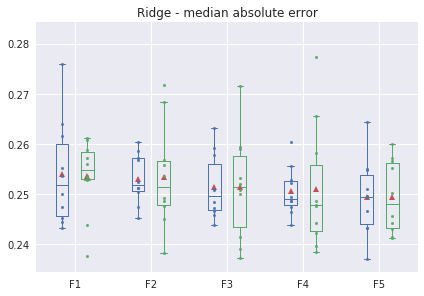

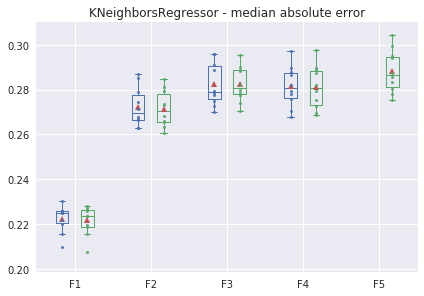

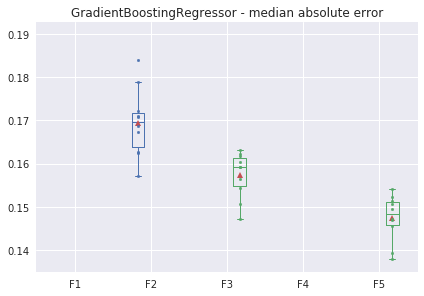

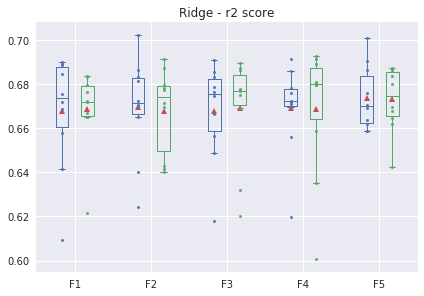

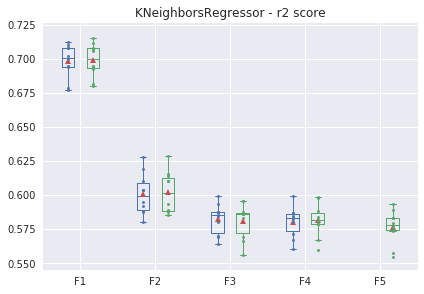

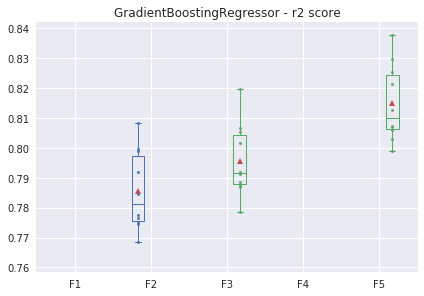

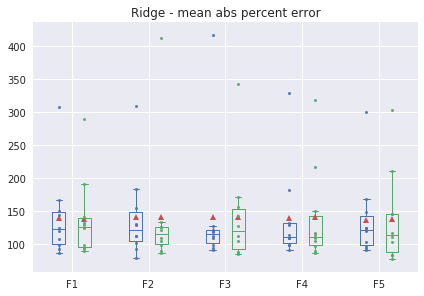

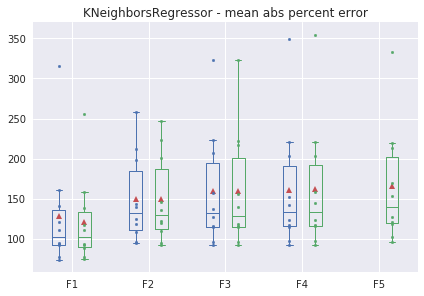

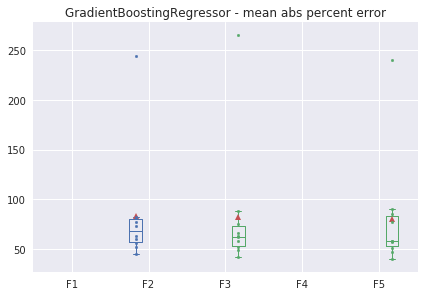

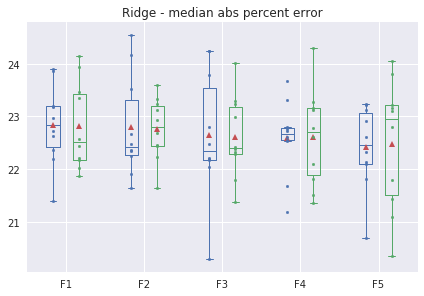

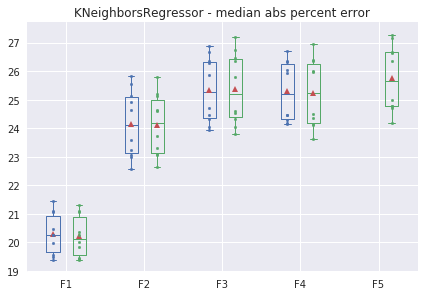

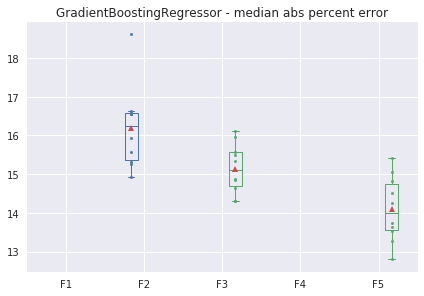

In [4]:
for met in res.metric.unique():
    plt.show(make_base_plot(res, 'Ridge', True, met, 'manuscript/images')[0])
    plt.show(make_base_plot(res, 'KNeighborsRegressor', True, met, 'manuscript/images')[0])
    plt.show(make_base_plot(res, 'GradientBoostingRegressor', True, met, 'manuscript/images')[0])

## generation of tables

In [147]:
# for now we dont have nomost results, so we just copy the most ones
# so that we can preview how the tables will look like once they are complete
all_most = {'most', 'nomost'}
missing = all_most - set(res.most)
if missing:
    print('*** WARNING')
    print('replacing missing values in %s with fake measures' % missing)
    allres, missing = [], list(missing)[0]
    for row in res.values:
        allres.append(row)
        newrow = [x for x in row]
        newrow[3] = missing
        allres.append(newrow)
    allres = pd.DataFrame(allres, columns=res.columns)
else:
    allres = res

*** WARNING
replacing missing values in {'nomost'} with fake measures


In [157]:
# rename stuff
renamed = allres[
    (allres.metric != 'explained_variance_score')
].replace({
    'most': {'most': 'Y', 'nomost': 'N'},
    'trend': {'trend': 'Y', 'notrend': 'N'},
    'metric': {
        'mean_squared_error': 'MSE',
        'median_squared_error': 'mSE',
        'mean_absolute_error': 'MAE',
        'median_absolute_error': 'mAE',
        'mean_abs_percent_error': 'MAPE',
        'median_abs_percent_error': 'mAPE',
        'r2_score': '$R^2$',
    },
    'features': {'f1': 'F1', 'f2': 'F2', 'f3': 'F3', 'f4': 'F4', 'f5': 'F5'}
}).rename(columns={
    'features': 'Features',
    'metric': 'Metric',
    'trend': 'Trend',
    'most': 'MOST'
})


# one table for each estimator
for estimator in renamed.estimator.unique():
    est_res = renamed[
        renamed.estimator == estimator
    ].pivot_table(
        columns='Features',
        values='value',
        index=['Metric', 'MOST', 'Trend'],
        aggfunc=lambda vals: '%.4f (%.4f)' % (vals.mean(), vals.std())
    )
    
    # useless and pollute output
    est_res.index.name = ''
    est_res.columns.name = ''
    
    # change order of metrics
    est_res = est_res.reindex([
        'MSE', '$R^2$', 'MAE', 'mAE', 'MAPE', 'mAPE'
    ], level=0)
    display(est_res)

    # use makecell to insert a line break between mean and std
    def format_col(text):
        return '\makecell[c]{%s}' % text.replace(' ', r'\\')

    latex = est_res.to_latex(
        escape=False,
        bold_rows=True,
        column_format='asd',
        multirow=True,
        formatters={
            'F1': format_col,
            'F2': format_col,
            'F3': format_col,
            'F4': format_col,
            'F5': format_col,
        }
    )

    # replace double clines with a single hline
    latex = re.sub(r'\\cline{.*?}\n\\cline{.*?}', '\hline', latex)
    
    # add tiny vertical space between cells
    # somewhat helps readability
    latex = '\centering\setcellgapes{0.15ex}\makegapedcells' + latex
    
    # since we used makecell to insert newlines inside each cell, we have
    # to double the vertical size of the multirows
    # also move metric name slightly upwards to make it aligned with center line
    # (move up by 1ex and down by 0.15ex to balance the padding)
    latex = re.sub(r'\\multirow{(\d+)}{\*}{(.*?)}', 
                   lambda m: r'\multirowcell{%d}[0.75ex][c]{%s}' % (2 * int(m[1]), m[2]),
                   latex)

    # use tabular* environment to make table fill the page width
    latex = latex.replace(
        r'\begin{tabular}{asd}',
        r'\begin{tabular*}{\textwidth}{l @{\extracolsep{\fill}} ll|ccccc}'
    ).replace(r'\end{tabular}', r'\end{tabular*}')
    
    with open('manuscript/include/results_%s.tex' % estimator, 'w') as f:
        f.write(latex)

F1                  F2                  F3  \
Metric MOST Trend                                                               
MSE    N    N         0.2736 (0.0231)     0.2738 (0.0214)     0.2732 (0.0237)   
            Y         0.2747 (0.0267)     0.2733 (0.0243)     0.2738 (0.0218)   
       Y    N         0.2736 (0.0231)     0.2738 (0.0214)     0.2732 (0.0237)   
            Y         0.2747 (0.0267)     0.2733 (0.0243)     0.2738 (0.0218)   
$R^2$  N    N         0.6686 (0.0180)     0.6679 (0.0194)     0.6692 (0.0236)   
            Y         0.6678 (0.0257)     0.6696 (0.0227)     0.6679 (0.0219)   
       Y    N         0.6686 (0.0180)     0.6679 (0.0194)     0.6692 (0.0236)   
            Y         0.6678 (0.0257)     0.6696 (0.0227)     0.6679 (0.0219)   
MAE    N    N         0.3574 (0.0145)     0.3576 (0.0147)     0.3564 (0.0164)   
            Y         0.3582 (0.0172)     0.3572 (0.0131)     0.3567 (0.0110)   
       Y    N         0.3574 (0.0145)     0.3576 (0.0147)     0.3564 (0.0164)   
            Y         0.3582 (0.0172)     0.3572 (0.0131)     0.3567 (0.0110)   
mAE    N    N         0.2535 (0.0075)     0.2535 (0.0103)     0.2513 (0.0105)   
            Y         0.2540 (0.0104)     0.2531 (0.0050)     0.2514 (0.0064)   
       Y    N         0.2535 (0.0075)     0.2535 (0.0103)     0.2513 (0.0105)   
            Y         0.2540 (0.0104)     0.2531 (0.0050)     0.2514 (0.0064)   
MAPE   N    N      138.1894 (61.6329)  140.6039 (96.7898)  141.1843 (76.8901)   
            Y      139.5417 (64.7846)  140.3263 (66.9258)  140.5540 (97.8109)   
       Y    N      138.1894 (61.6329)  140.6039 (96.7898)  141.1843 (76.8901)   
            Y      139.5417 (64.7846)  140.3263 (66.9258)  140.5540 (97.8109)   
mAPE   N    N        22.8163 (0.8345)    22.7656 (0.5907)    22.6120 (0.7738)   
            Y        22.8427 (0.7638)    22.7917 (0.9647)    22.6463 (1.2033)   
       Y    N        22.8163 (0.8345)    22.7656 (0.5907)    22.6120 (0.7738)   
            Y        22.8427 (0.7638)    22.7917 (0.9647)    22.6463 (1.2033)   

                                   F4                  F5  
Metric MOST Trend                                          
MSE    N    N         0.2735 (0.0257)     0.2694 (0.0177)  
            Y         0.2725 (0.0163)     0.2702 (0.0209)  
       Y    N         0.2735 (0.0257)     0.2694 (0.0177)  
            Y         0.2725 (0.0163)     0.2702 (0.0209)  
$R^2$  N    N         0.6689 (0.0297)     0.6730 (0.0145)  
            Y         0.6693 (0.0198)     0.6737 (0.0145)  
       Y    N         0.6689 (0.0297)     0.6730 (0.0145)  
            Y         0.6693 (0.0198)     0.6737 (0.0145)  
MAE    N    N         0.3563 (0.0178)     0.3539 (0.0117)  
            Y         0.3559 (0.0088)     0.3543 (0.0128)  
       Y    N         0.3563 (0.0178)     0.3539 (0.0117)  
            Y         0.3559 (0.0088)     0.3543 (0.0128)  
mAE    N    N         0.2510 (0.0124)     0.2495 (0.0073)  
            Y         0.2506 (0.0048)     0.2494 (0.0076)  
       Y    N         0.2510 (0.0124)     0.2495 (0.0073)  
            Y         0.2506 (0.0048)     0.2494 (0.0076)  
MAPE   N    N      140.1562 (73.4323)  137.6390 (70.4563)  
            Y      138.8133 (71.5734)  136.6003 (62.3008)  
       Y    N      140.1562 (73.4323)  137.6390 (70.4563)  
            Y      138.8133 (71.5734)  136.6003 (62.3008)  
mAPE   N    N        22.6037 (0.9156)    22.4800 (1.2354)  
            Y        22.5818 (0.7164)    22.4147 (0.7906)  
       Y    N        22.6037 (0.9156)    22.4800 (1.2354)  
            Y        22.5818 (0.7164)    22.4147 (0.7906)

F1                  F2                  F3  \
Metric MOST Trend                                                               
MSE    N    N         0.2490 (0.0214)     0.3288 (0.0221)     0.3462 (0.0222)   
            Y         0.2495 (0.0214)     0.3299 (0.0229)     0.3456 (0.0266)   
       Y    N         0.2490 (0.0214)     0.3288 (0.0221)     0.3462 (0.0222)   
            Y         0.2495 (0.0214)     0.3299 (0.0229)     0.3456 (0.0266)   
$R^2$  N    N         0.6990 (0.0123)     0.6020 (0.0153)     0.5810 (0.0132)   
            Y         0.6984 (0.0125)     0.6007 (0.0151)     0.5821 (0.0114)   
       Y    N         0.6990 (0.0123)     0.6020 (0.0153)     0.5810 (0.0132)   
            Y         0.6984 (0.0125)     0.6007 (0.0151)     0.5821 (0.0114)   
MAE    N    N         0.3301 (0.0122)     0.3913 (0.0117)     0.4023 (0.0116)   
            Y         0.3308 (0.0119)     0.3922 (0.0121)     0.4020 (0.0144)   
       Y    N         0.3301 (0.0122)     0.3913 (0.0117)     0.4023 (0.0116)   
            Y         0.3308 (0.0119)     0.3922 (0.0121)     0.4020 (0.0144)   
mAE    N    N         0.2216 (0.0065)     0.2715 (0.0082)     0.2824 (0.0079)   
            Y         0.2224 (0.0060)     0.2724 (0.0088)     0.2825 (0.0096)   
       Y    N         0.2216 (0.0065)     0.2715 (0.0082)     0.2824 (0.0079)   
            Y         0.2224 (0.0060)     0.2724 (0.0088)     0.2825 (0.0096)   
MAPE   N    N      120.5791 (54.4785)  149.0417 (54.7499)  159.2523 (73.4756)   
            Y      127.9517 (71.4139)  149.3273 (55.2830)  159.1678 (72.4943)   
       Y    N      120.5791 (54.4785)  149.0417 (54.7499)  159.2523 (73.4756)   
            Y      127.9517 (71.4139)  149.3273 (55.2830)  159.1678 (72.4943)   
mAPE   N    N        20.2197 (0.7305)    24.1185 (1.0874)    25.3930 (1.2562)   
            Y        20.3036 (0.7305)    24.1559 (1.1887)    25.3545 (1.1661)   
       Y    N        20.2197 (0.7305)    24.1185 (1.0874)    25.3930 (1.2562)   
            Y        20.3036 (0.7305)    24.1559 (1.1887)    25.3545 (1.1661)   

                                   F4                  F5  
Metric MOST Trend                                          
MSE    N    N         0.3461 (0.0258)     0.3502 (0.0259)  
            Y         0.3473 (0.0261)                None  
       Y    N         0.3461 (0.0258)     0.3502 (0.0259)  
            Y         0.3473 (0.0261)                None  
$R^2$  N    N         0.5814 (0.0122)     0.5765 (0.0125)  
            Y         0.5800 (0.0112)                None  
       Y    N         0.5814 (0.0122)     0.5765 (0.0125)  
            Y         0.5800 (0.0112)                None  
MAE    N    N         0.4015 (0.0143)     0.4073 (0.0138)  
            Y         0.4023 (0.0141)                None  
       Y    N         0.4015 (0.0143)     0.4073 (0.0138)  
            Y         0.4023 (0.0141)                None  
mAE    N    N         0.2810 (0.0097)     0.2883 (0.0096)  
            Y         0.2815 (0.0091)                None  
       Y    N         0.2810 (0.0097)     0.2883 (0.0096)  
            Y         0.2815 (0.0091)                None  
MAPE   N    N      162.3735 (79.6338)  165.1571 (73.0099)  
            Y      161.0464 (78.3605)                None  
       Y    N      162.3735 (79.6338)  165.1571 (73.0099)  
            Y      161.0464 (78.3605)                None  
mAPE   N    N        25.2427 (1.2008)    25.7516 (1.1676)  
            Y        25.2902 (1.0582)                None  
       Y    N        25.2427 (1.2008)    25.7516 (1.1676)  
            Y        25.2902 (1.0582)                None

F2                 F3                 F5
Metric MOST Trend                                                         
MSE    N    N                   None    0.1690 (0.0169)    0.1531 (0.0155)
            Y        0.1773 (0.0159)               None               None
       Y    N                   None    0.1690 (0.0169)    0.1531 (0.0155)
            Y        0.1773 (0.0159)               None               None
$R^2$  N    N                   None    0.7957 (0.0122)    0.8149 (0.0129)
            Y        0.7856 (0.0133)               None               None
       Y    N                   None    0.7957 (0.0122)    0.8149 (0.0129)
            Y        0.7856 (0.0133)               None               None
MAE    N    N                   None    0.2554 (0.0103)    0.2409 (0.0100)
            Y        0.2680 (0.0115)               None               None
       Y    N                   None    0.2554 (0.0103)    0.2409 (0.0100)
            Y        0.2680 (0.0115)               None               None
mAE    N    N                   None    0.1575 (0.0052)    0.1475 (0.0054)
            Y        0.1695 (0.0079)               None               None
       Y    N                   None    0.1575 (0.0052)    0.1475 (0.0054)
            Y        0.1695 (0.0079)               None               None
MAPE   N    N                   None  82.2009 (65.5704)  80.6549 (58.3509)
            Y      83.5541 (57.9430)               None               None
       Y    N                   None  82.2009 (65.5704)  80.6549 (58.3509)
            Y      83.5541 (57.9430)               None               None
mAPE   N    N                   None   15.1460 (0.6481)   14.1055 (0.8466)
            Y       16.1926 (1.0681)               None               None
       Y    N                   None   15.1460 (0.6481)   14.1055 (0.8466)
            Y       16.1926 (1.0681)               None               None